# BIONIC Methods Tests and Data Visualization

## Exploration and Gene Filtering

In [3]:
import pickle
# imports
from itertools import combinations
import numpy as np
import pandas as pd
import csv
# import pearsonr as pearsonr
# from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import argparse
import networkx as nx

In [3]:
#File Read
# df = pd.read_csv("../outputs/previous_attemps/locus_tag_processed.csv", sep=',', index_col=0, header=0)
# df

In [207]:
# df.index.isna().sum()

0

### Retrieve number of probe names with aliases

In [25]:
# unique_entries = set()
# all_entries = set()
#
# with open('../outputs/separate_conditions/edgelist_16mad_pn999_probe.txt', 'r') as file:
#     for line in file:
#         entries = line.strip().split(' ')[:2]
#         all_entries.update(entries)
#         for entry in entries:
#             if ';' in entry:
#                 unique_entries.add(entry)  # Add entry to the set
#
# # Count the number of unique entries
# count = len(unique_entries)
# num_all_entries = len(all_entries)
# percent = count / num_all_entries * 100
#
#
# print(f"Number of unique entries containing at least one semicolon and respective percentage: {count} ({percent:.2f}%)")
#
# with open('semicolon-entries.txt', 'w') as file:
#     for entry in unique_entries:
#         file.write(entry + '\n')

Number of unique entries containing at least one semicolon and respective percentage: 99 (6.67%)


### Pre-processes the probe names
Pre-processed the gene expression data, separating the probe names and removing the probes from organs (ATC and ATM).

In [208]:
# with open('../outputs/previous_attemps/locus_tag_processed.csv', 'r') as file:
#     reader = csv.reader(file)
#     header = next(reader)
#     new_rows = []
#
#     for row in reader:
#         probe_names = [row[0][i:i+9] for i in range(0, len(row[0]), 9)]
#
#         # Filter out probes from organs (ATC and ATM)
#         probe_names = [probe for probe in probe_names if not probe.startswith('ATC') and not probe.startswith('ATM')]
#
#         # Remove ATM and ATC from the list of probe names if they are aliases
#         for i in range(len(probe_names)):
#             if probe_names[i] == 'ATC' or probe_names[i] == 'ATM':
#                 probe_names.pop(i)
#
#         if len(probe_names) > 0:
#             new_row = [';'.join(probe_names)] + row[1:]
#             new_rows.append(new_row)
#
# with open('../outputs/probes_alias_sep.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(header)
#     writer.writerows(new_rows)

In [214]:
#File Read
# df = pd.read_csv("../outputs/current_df/probes_alias_sep.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

###  Map probe names to gene symbols
Map the probe names to gene symbols.

In [211]:
# def map_probes_to_genes(input_file, mapping_file):
#     # Read the mapping file and create a dictionary mapping probe names to gene symbols
#     probe_to_gene = {}
#     with open(mapping_file, 'r') as map_file:
#         for line in map_file:
#             probe, gene = line.strip().split()
#             probe_to_gene[probe] = gene
#
#     # Read in the input file as a DataFrame
#     input_df = pd.read_csv(input_file)
#
#     # Map the gene symbols for each probe name
#     gene_symbols = []
#     for probe_name in input_df['probe_name']:
#         sub_probes = probe_name.split(';')
#         gene_symbol = ''
#         if len(sub_probes) > 1:
#             gene_symbol += ';'.join([probe_to_gene.get(sub_probe, sub_probe) for sub_probe in sub_probes])
#         else:
#             gene_symbol += probe_to_gene.get(sub_probes[0], sub_probes[0])
#         gene_symbols.append(gene_symbol)
#
#     # Replace the "probe_name" column with "gene_symbol"
#     input_df['gene_symbol'] = gene_symbols
#     input_df = input_df.drop(columns=['probe_name'])
#     input_df = input_df.set_index('gene_symbol')
#
#     # Write the output file
#     input_df.to_csv('../outputs/current_df/genesymb_processed.csv')
#
# map_probes_to_genes('../outputs/probes_alias_sep.csv', '../gene_mapping/gene_symbol_mapping.txt')

In [213]:
#File Read
# df = pd.read_csv("../outputs/current_df/genesymb_processed.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

## Scaling and Filtering

In [5]:
#File Read
df = pd.read_csv("../outputs/previous_attemps/probes_alias_sep.csv", sep=',', index_col=0, header=0)
df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
probe_name,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
AT1G50760,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
AT1G56310,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


In [6]:
# Check the value ranges of the expression values for each conditions
grouped_data = df.groupby(df.columns, axis=1)
grouped_data.describe()

,,count,mean,std,min,25%,50%,75%,max
35D-0H-16C-A,35D-0H-16C-A,22553.0,275.946020,697.108922,0.0,17.8,78.4,250.6,11717.7
35D-0H-16C-B,35D-0H-16C-B,22553.0,266.573037,630.579840,0.0,15.8,81.3,255.6,9982.1
35D-2H-16C-A,35D-2H-16C-A,22553.0,274.251581,680.855354,0.0,20.1,83.2,252.4,11184.2
37D-2H-16C-B,37D-2H-16C-B,22553.0,268.955412,648.300507,0.0,16.2,83.0,252.4,9832.8
37D-2H-25C-A,37D-2H-25C-A,22553.0,271.357150,660.357147,0.0,20.3,87.9,256.1,11547.8
37D-2H-25C-B,37D-2H-25C-B,22553.0,269.751080,659.436351,0.1,16.7,86.4,255.3,10688.8
40D-5H-16C-A,40D-5H-16C-A,22553.0,271.262497,657.703709,0.0,16.0,81.3,256.2,10244.4
40D-5H-16C-B,40D-5H-16C-B,22553.0,271.353314,668.348653,0.0,19.8,84.4,250.9,10996.7
40D-5H-25C-A,40D-5H-25C-A,22553.0,270.113759,652.476525,0.1,20.6,87.8,258.6,11045.5
40D-5H-25C-B,40D-5H-25C-B,22553.0,270.886463,670.787552,0.2,18.3,85.3,255.7,11509.6


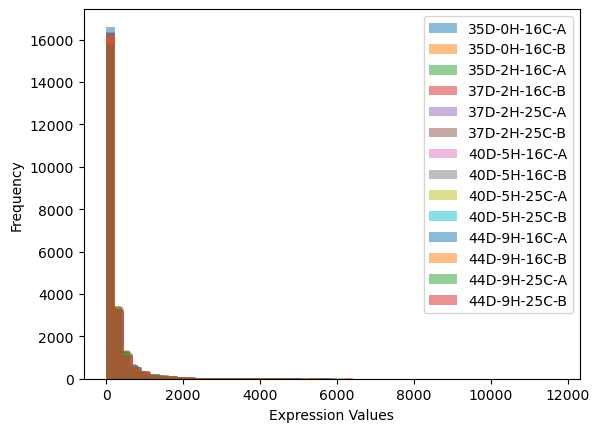

In [7]:
# Plot distribution of expression values for each condition

for sample, group in grouped_data:
    plt.hist(group[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.legend()

plt.show()

### Separate datasets by conditions

In [8]:
# Separate dataset by temperatures
sixteen_df = df.iloc[:, :8]
sixteen_df.to_csv("../outputs/separate_conditions/sixteen_df_probe.csv")
twenty_five_df = df.iloc[:, 8:16]
twenty_five_df.to_csv("../outputs/separate_conditions/twenty_five_df_probe.csv")

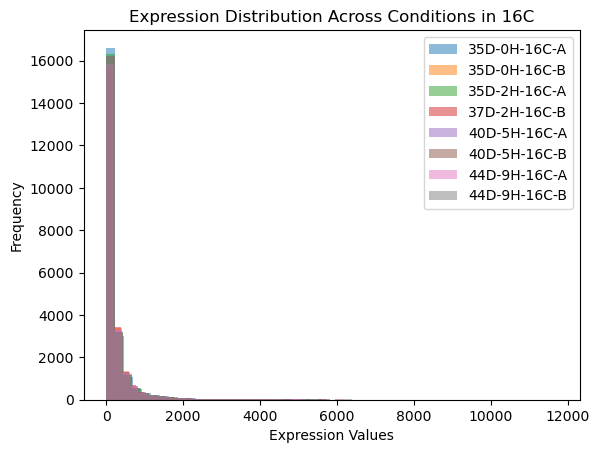

In [9]:
# Expression distribution across conditions in 16C
grouped_sixteen = sixteen_df.groupby(sixteen_df.columns, axis=1)

for sample, condition in grouped_sixteen:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 16C")
plt.legend()

plt.show()

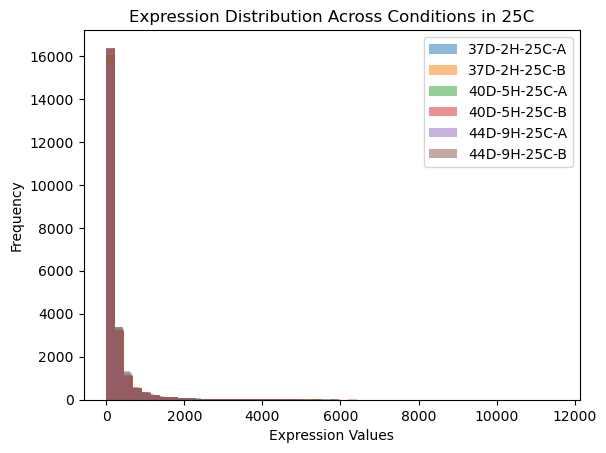

In [10]:
# Expression distribution across conditions in 25C
grouped_twenty_five = twenty_five_df.groupby(twenty_five_df.columns, axis=1)

for sample, condition in grouped_twenty_five:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 25C")
plt.legend()

plt.show()

In [121]:
# Read condition files
sixteen_df = pd.read_csv("../outputs/separate_conditions/sixteen_df_probe.csv")
twenty_five_df = pd.read_csv("../outputs/separate_conditions/twenty_five_df_probe.csv")

In [122]:
sixteen_df.dropna(inplace=True)
sixteen_df.set_index('probe_name', inplace=True)

In [123]:
twenty_five_df.dropna(inplace=True)
twenty_five_df.set_index('probe_name', inplace=True)

### Filter by Coefficient of Variation

In [25]:
# Calculate CoV for 16C

# Calculate the mean and standard deviation for each gene
sixteen_mean = sixteen_df.mean(axis=1)
sixteen_std = sixteen_df.std(axis=1)

# Calculate the coefficient of variation for each gene
sixteen_cv = (sixteen_std / sixteen_mean) * 100

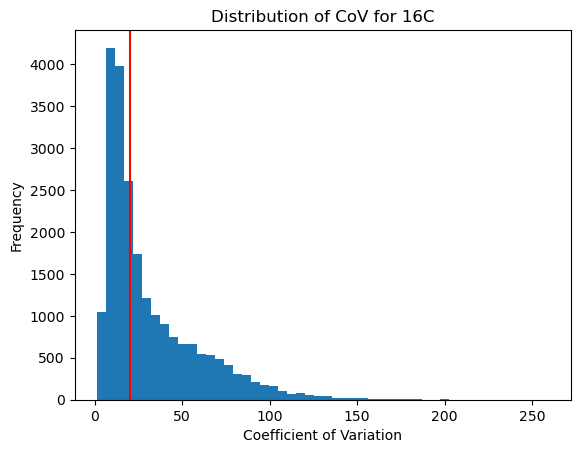

In [26]:
# Visualize CoV
plt.hist(sixteen_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 16C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [27]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_sixteen_genes = sixteen_cv[sixteen_cv >= threshold].index.tolist()
filtered_sixteen_df = sixteen_df.loc[filtered_sixteen_genes, :]
print(len(filtered_sixteen_genes))

11578


In [28]:
# Calculate CoV for 25C

# Calculate the mean and standard deviation for each gene
twenty_five_mean = twenty_five_df.mean(axis=1)
twenty_five_std = twenty_five_df.std(axis=1)

# Calculate the coefficient of variation for each gene
twenty_five_cv = (twenty_five_std / twenty_five_mean) * 100

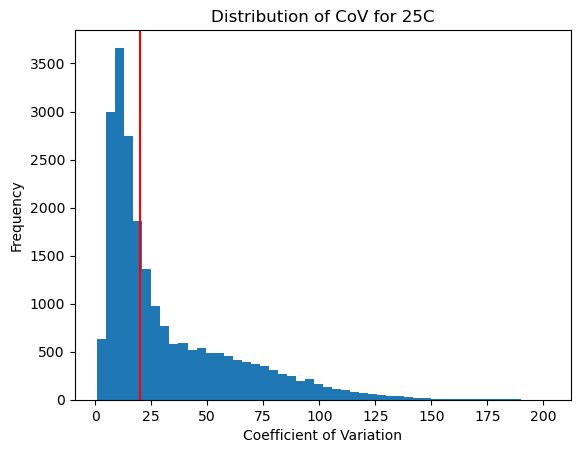

In [29]:
# Visualize CoV
plt.hist(twenty_five_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 25C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [30]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_cov_twentyfive_genes = twenty_five_cv[twenty_five_cv >= threshold].index.tolist()
filtered_twentyfive_cov_df = twenty_five_df.loc[filtered_cov_twentyfive_genes, :]
print(len(filtered_cov_twentyfive_genes))

10999


### Filter by Mean Absolute Deviation

In [124]:
# Calculate MAD for each gene in 16C

sixteen_mad = np.mean(np.abs(sixteen_df - sixteen_df.mean()), axis=1)
sixteen_median_mad = np.median(sixteen_mad)

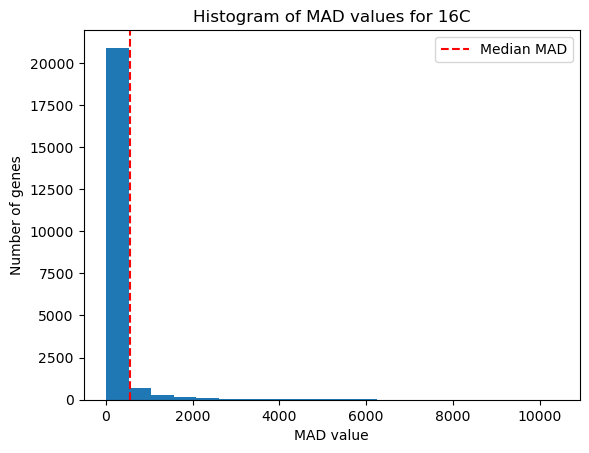

In [111]:
# Visualize MAD values
median_threshold = sixteen_median_mad * 2.4
plt.hist(sixteen_mad, bins=20)
plt.axvline(x=median_threshold, color='red', linestyle='--', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 16C')
plt.legend()
plt.show()

In [125]:
# Filter out by the median of the MAD value
median_threshold = sixteen_median_mad * 2.4
filtered_sixteen_mad = sixteen_df.loc[sixteen_mad >= median_threshold, :]
print(len(filtered_sixteen_mad))

1484


In [126]:
# Calculate MAD for each gene in 25C

twenty_five_mad = np.mean(np.abs(twenty_five_df - twenty_five_df.mean()), axis=1)
twenty_five_median_mad = np.median(twenty_five_mad)

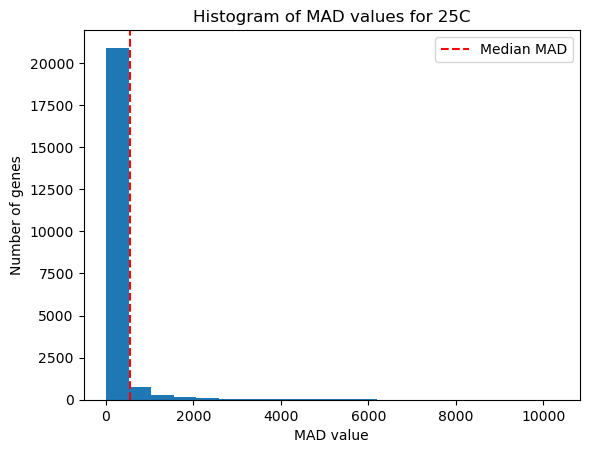

In [114]:
# Visualize MAD values for 25C
median_threshold = twenty_five_median_mad * 2.4
plt.hist(twenty_five_mad, bins=20)
plt.axvline(x=median_threshold, color='red', linestyle='--', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 25C')
plt.legend()
plt.show()

In [127]:
# Filter out by the median of the MAD value
filtered_twenty_five_mad = twenty_five_df.loc[twenty_five_mad >= median_threshold, :]
print(len(filtered_twenty_five_mad))

1467


In [118]:
# Check if filtered genes from both conditions match
filtered_sixteen_mad_genes = filtered_sixteen_mad.index.tolist()
filtered_twenty_five_mad_genes = filtered_twenty_five_mad.index.tolist()
print(len(filtered_sixteen_mad_genes))
print(len(filtered_twenty_five_mad_genes))
print(len(set(filtered_sixteen_mad_genes).intersection(filtered_twenty_five_mad_genes)))

1484
1483
1310


In [129]:
filtered_sixteen_mad.to_csv("../outputs/separate_conditions/filtered_sixteen_mad.csv")
filtered_twenty_five_mad.to_csv("../outputs/separate_conditions/filtered_twenty_five_mad.csv")

In [132]:
def add_all_flowering_genes(original_dataset, filtered_dataset, flowering_mapping_file, output_file):
    original_dataset = pd.read_csv(original_dataset, index_col=0)
    filtered_dataset = pd.read_csv(filtered_dataset, index_col=0)

    with open(flowering_mapping_file, 'r') as f:
            flowering_genes = [line.strip() for line in f]

    matching_flowering_genes = original_dataset.loc[original_dataset.index.isin(flowering_genes)]

    filtered_data = pd.concat([filtered_dataset, matching_flowering_genes])
    filtered_data.to_csv(output_file)
    return filtered_data

add_all_flowering_genes("../outputs/separate_conditions/sixteen_df_probe.csv", "../outputs/separate_conditions/filtered_sixteen_mad.csv", "../gene_mapping/flowerid_locus.txt", "../outputs/separate_conditions/16mad_flowering.csv")

add_all_flowering_genes("../outputs/separate_conditions/twenty_five_df_probe.csv", "../outputs/separate_conditions/filtered_twenty_five_mad.csv", "../gene_mapping/flowerid_locus.txt", "../outputs/separate_conditions/25mad_flowering.csv")

,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
probe_name,,,,,,
AT2G42210,2913.2,2294.4,2580.2,2314.7,2559.5,2477.0
AT2G33040,2106.4,2437.6,2116.1,2451.6,1974.5,2292.9
AT2G39700,821.4,834.3,1207.4,907.2,902.7,1023.0
AT2G32180;AT2G32650,923.6,811.2,677.9,877.0,926.7,844.5
AT2G45710,875.2,697.2,796.1,769.4,905.9,845.5
...,...,...,...,...,...,...
AT4G16280,116.8,108.2,141.2,120.6,133.4,134.1
AT4G16845,254.6,272.2,248.7,241.5,275.1,251.6
AT4G25530,35.7,16.2,34.2,30.8,17.2,37.0


### Filter Ben's recomendation

In [79]:
# Read condition files
sixteen_df = pd.read_csv("../outputs/separate_conditions/sixteen_df_probe.csv")
twenty_five_df = pd.read_csv("../outputs/separate_conditions/twenty_five_df_probe.csv")

In [80]:
sixteen_df.dropna(inplace=True)
sixteen_df.set_index('probe_name', inplace=True)

In [81]:
twenty_five_df.dropna(inplace=True)
twenty_five_df.set_index('probe_name', inplace=True)

In [82]:
log2_dataset16 = np.log2(sixteen_df + 1e-8)
log2_dataset25 = np.log2(twenty_five_df + 1e-8)

In [46]:
log2_dataset16.to_csv("../outputs/separate_conditions/norm16.csv")
log2_dataset25.to_csv("../outputs/separate_conditions/norm25.csv")

In [87]:
# Mean Absolute Deviation
sixteen_mad = np.mean(np.abs(log2_dataset16 - log2_dataset16.mean()), axis=1)
twenty_five_mad = np.mean(np.abs(log2_dataset25 - log2_dataset25.mean()), axis=1)

In [94]:
# Filter the first 2000 genes with the best MAD values
top16_ind = np.argsort(-sixteen_mad)[:2000]
top25_ind = np.argsort(-twenty_five_mad)[:2000]

top16_genes = log2_dataset16.index[top16_ind]
top25_genes = log2_dataset25.index[top25_ind]

filtered16_data = log2_dataset16.loc[top16_genes]
filtered25_data = log2_dataset25.loc[top25_genes]

In [96]:
filtered16_data.to_csv("../outputs/separate_conditions/16mad_ben.csv")
filtered25_data.to_csv("../outputs/separate_conditions/25mad_ben.csv")

In [32]:
def check_number_of_alias_in_flowering_genes(dataset, flowering_map_file):
    """
    Check how many genes in the flowering genes list are present in the dataset semicolon-separated index.
    :param dataset: dataset with semicolon-separated index
    :param flowering_genes: flowering genes file
    :return: number of matching entries
    """
    with open(flowering_map_file, 'r') as f:
        flowering_genes = [line.strip() for line in f]

    data = pd.read_csv(dataset, index_col=0)
    dataset_semicindex = data[data.index.str.contains(';')]
    list = dataset_semicindex.index.to_list()
    separated_list = [entry.split(";") for entry in list]

    matching_entries = 0

    for entry in list:
        if entry in flowering_genes:
            matching_entries += 1

    print("Number of matching entries:", matching_entries)

check_number_of_alias_in_flowering_genes("../bionic/norm_predictions/2norm_recon_features.tsv", "../gene_mapping/flowerid_locus.txt")

Number of matching entries: 0


In [ ]:
def add_all_flowering_genes(original_dataset, filtered_dataset, flowering_mapping_file, output_file):
    original_dataset = pd.read_csv(original_dataset, index_col=0)
    filtered_dataset = pd.read_csv(filtered_dataset, index_col=0)

    with open(flowering_mapping_file, 'r') as f:
            flowering_genes = [line.strip() for line in f]

    matching_flowering_genes = original_dataset.loc[original_dataset.index.isin(flowering_genes)]

    filtered_data = pd.concat([filtered_dataset, matching_flowering_genes])
    filtered_data.to_csv(output_file)
    return filtered_data

add_all_flowering_genes("../outputs/separate_conditions/norm16.csv", "../outputs/separate_conditions/16mad_ben.csv", "../gene_mapping/flowerid_locus.txt", "../outputs/separate_conditions/16mad_ben_flowering.csv")

add_all_flowering_genes("../outputs/separate_conditions/norm25.csv", "../outputs/separate_conditions/25mad_ben.csv", "../gene_mapping/flowerid_locus.txt", "../outputs/separate_conditions/25mad_ben_flowering.csv")

In [54]:
# Check if filtered genes from both conditions match
# filtered_sixteen_mad_genes = filtered_sixteen_mad.index.tolist()
# filtered_twenty_five_mad_genes = filtered_twenty_five_mad.index.tolist()
print(len(top16_genes))
print(len(top25_genes))
print(len(set(top16_genes).intersection(top25_genes)))

2000
2000
1588


In [ ]:
# Plot the MAD values for 16C
plt.hist(sixteen_mad, bins=20)
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 16C')
plt.show()

In [ ]:
# Plot the MAD values for 25C
plt.hist(twenty_five_mad, bins=20)
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 25C')
plt.show()

## Scale filtered datasets

In [240]:
# Scale values by individual samples
scaler_sixteen_cov = StandardScaler()
scaled_sixteen_cov = scaler_sixteen_cov.fit_transform(filtered_sixteen_df)
scaled_sixteen_cov = pd.DataFrame(scaled_sixteen_cov, columns=filtered_sixteen_df.columns, index=filtered_sixteen_df.index)
scaled_sixteen_cov.to_csv("../outputs/separate_conditions/scaled_sixteen_cov.csv")

In [241]:
scaler_twentyfive_cov = StandardScaler()
scaled_twenty_five_cov = scaler_twentyfive_cov.fit_transform(filtered_twentyfive_cov_df)
scaled_twenty_five_cov = pd.DataFrame(scaled_twenty_five_cov, columns=filtered_twentyfive_cov_df.columns, index=filtered_twentyfive_cov_df.index)
scaled_twenty_five_cov.to_csv("../outputs/separate_conditions/scaled_twenty_five_cov.csv")

In [39]:
scaler_sixteen_mad = StandardScaler()
scaled_sixteen_mad = scaler_sixteen_mad.fit_transform(filtered_sixteen_mad)
scaled_sixteen_mad = pd.DataFrame(scaled_sixteen_mad, columns=filtered_sixteen_mad.columns, index=filtered_sixteen_mad.index)
scaled_sixteen_mad.to_csv("../outputs/separate_conditions/scaled_sixteen_mad_probe.csv")

In [40]:
scaler_twentyfive_mad = StandardScaler()
scaled_twenty_five_mad = scaler_twentyfive_mad.fit_transform(filtered_twenty_five_mad)
scaled_twenty_five_mad = pd.DataFrame(scaled_twenty_five_mad, columns=filtered_twenty_five_mad.columns, index=filtered_twenty_five_mad.index)
scaled_twenty_five_mad.to_csv("../outputs/separate_conditions/scaled_twenty_five_mad_probe.csv")

## Degree Distribution Plot
Plots the probability of distribution of the network's degrees

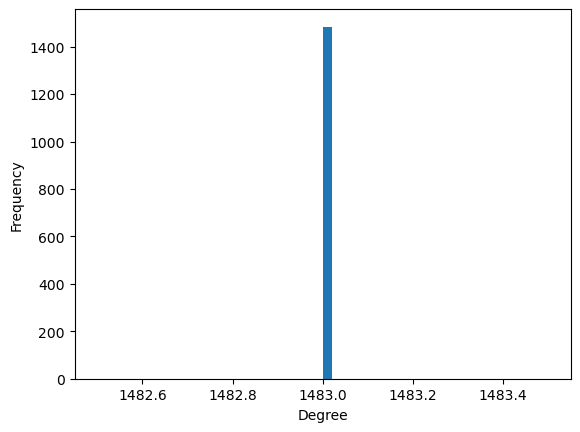

In [15]:
# Degree distribution for 16C
import networkx as nx

# Read edgelist file into a numpy array
edgelist16 = np.loadtxt('../bionic/binary_run/16mad_binary.txt', dtype='str')

# Convert weights column to float data type
#edgelist16[:, 2] = edgelist16[:, 2].astype(np.float64)

# Create a networkx graph object from the edgelist
G16 = nx.Graph()
G16.add_edges_from(edgelist16)

# Calculate degree of each node in the graph
degrees16 = dict(G16.degree())

# Plot degree distribution as a histogram
plt.hist(list(degrees16.values()), bins=50)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('degree_distribution16cov.png')
plt.show()

## Network average degree
Average degree is the average number of edges per node in a graph.

In [17]:
def average_degree_weighted_network(edgelist_file):
    edgelist = np.loadtxt(edgelist_file, dtype='str')
    edgelist[:, 2] = edgelist[:, 2].astype(np.float64)

    G = nx.Graph()
    G.add_weighted_edges_from(edgelist)

    num_nodes = G.number_of_nodes() # get the number of nodes in the graph
    avg_degree = sum(dict(G.degree()).values()) / num_nodes # calculate the average degree of the nodes in the graph

    print(f"The network has {num_nodes} nodes and {G.number_of_edges()} edges.")
    print(f"The network has an average degree of {avg_degree:.2f}.")

average_degree_weighted_network("../bionic/random_run/25mad_random.txt")

The network has 1483 nodes and 1098903 edges.
The network has an average degree of 1482.00.


In [12]:
def average_degree_binary_network(edgelist_file):
    edgelist = np.loadtxt(edgelist_file, dtype='str')

    G = nx.Graph()
    G.add_edges_from(edgelist)

    num_nodes = G.number_of_nodes()  # get the number of nodes in the graph
    avg_degree = sum(dict(G.degree()).values()) / num_nodes  # calculate the average degree of the nodes in the graph

    print(f"The network has {num_nodes} nodes and {G.number_of_edges()} edges.")
    print(f"The network has an average degree of {avg_degree:.2f}.")

average_degree_binary_network("../bionic/binary_run/16mad_binary.txt")

The network has 1484 nodes and 1100386 edges.
The network has an average degree of 1483.00.


In [11]:
# Average Degree with NX function
edgelist = np.loadtxt('../outputs/current_df/sixteencov_edgelist_995corr.txt', dtype='str')

G = nx.Graph()
G.add_weighted_edges_from(edgelist)

num_nodes = G.number_of_nodes() # get the number of nodes in the graph
avg_degree = sum(dict(G.degree()).values()) / num_nodes # calculate the average degree of the nodes in the graph

print(f"The network has {num_nodes} nodes and {G.number_of_edges()} edges.")
print(f"The network has an average degree of {avg_degree:.2f}.")

MemoryError: Unable to allocate 19.9 GiB for an array with shape (11560603, 3) and data type <U154

In [ ]:
def degree_distribution(edgelist_file, output_file):
    # Read edgelist file into a numpy array
    edgelist = np.loadtxt(edgelist_file, dtype='str')

    # Convert weights column to float data type
    edgelist[:, 2] = edgelist[:, 2].astype(np.float64)

    # Create a networkx graph object from the edgelist
    G = nx.Graph()
    G.add_weighted_edges_from(edgelist)

    # Calculate degree of each node in the graph
    degrees = dict(G.degree())

    # Plot degree distribution as a histogram
    plt.hist(list(degrees.values()), bins=50)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.savefig(output_file)
    plt.show()

if __name__ == '__main__':
    # Define command line arguments
    parser = argparse.ArgumentParser(description='Calculate and plot the degree distribution of a graph')
    parser.add_argument('output_file', type=str, help='The output file name for the degree distribution plot')

    # Parse arguments
    args = parser.parse_args()

    # Call function with arguments
    degree_distribution(args.input_file, args.output_file)

In [2]:
with open("../bionic/bionic_evals/feature-module-labels.txt", "r") as f:
    lines = f.readlines()

num_rows = len(lines)

print("Number of rows in the file:", num_rows)

Number of rows in the file: 1383


In [3]:
with open("../bionic/bionic_evals/network-module-labels.txt", "r") as f:
    lines = f.readlines()

num_rows = len(lines)

print("Number of rows in the file:", num_rows)

Number of rows in the file: 1383


## Cluster Visualization

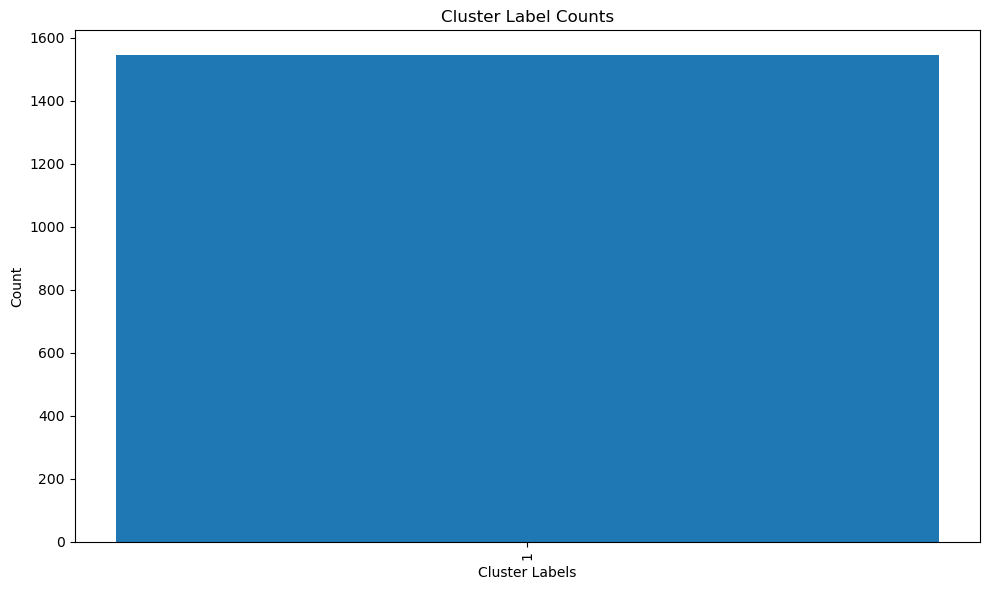

In [32]:
import matplotlib.pyplot as plt

# Read the text file with locus tags and cluster labels
with open('../bionic/labelled_run/feature-cluster-labels.txt', 'r') as file:
    lines = file.readlines()

# Extract cluster labels from the text file
cluster_labels = []
for line in lines:
    _, label = line.strip().split('\t')
    cluster_labels.append(label)

# Count the occurrences of each cluster label
label_counts = {}
for label in cluster_labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Prepare the data for the bar plot
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, counts)

# Set plot title and labels
plt.title('Cluster Label Counts')
plt.xlabel('Cluster Labels')
plt.ylabel('Count')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


In [34]:
print(len(counts))

1


In [7]:
import pickle
import pandas as pd

with open('../gene_mapping/flor_id_flowering_genes.pkl', 'rb') as file:
        data = pickle.load(file)

data = pd.DataFrame(data['locustag'])
# save the dataframe as a csv file
data.to_csv("../gene_mapping/flor_id_flowering_genes.csv")

In [21]:
# Number of unique genes in the edgelist file
import numpy as np

edgelist = np.loadtxt('../bionic/binary_run/25mad_binary.txt', dtype='str')

unique_genes = np.unique(edgelist[:, 0:2])
genes = []
for gene in unique_genes:
    genes.append(gene.split(';'))

print(f"There are {len(unique_genes)} unique genes in the edgelist file.")

There are 1483 unique genes in the edgelist file.


In [23]:
# See if any unique_genes match the flowering genes

# Read the flowering genes file
with open('../gene_mapping/flowerid_locus.txt', 'r') as file:
    lines = file.readlines()

# Extract the flowering genes
flowering_genes = []
for line in lines:
    gene = line.strip().split('\t')
    flowering_genes.append(gene)

# Check if any of the unique genes are flowering genes
matching_genes = []
for gene in flowering_genes:
    if gene in unique_genes:
        matching_genes.append(gene)

print(f"There are {len(matching_genes)} flowering genes in the edgelist file.")

There are 20 flowering genes in the edgelist file.


In [30]:
# Interval of predictions values

def prediction_interval(file_path):
    with open(file_path) as file:
        lines = file.readlines()

    # Extract the prediction values
    prediction_values = []
    for line in lines:
        _, value = line.strip().split('\t')
        value = value.strip('[]')  # Remove the square brackets
        prediction_values.append(float(value))

    # Find the minimum and maximum prediction values
    min_value = min(prediction_values)
    max_value = max(prediction_values)

    # Find average prediction value
    avg_value = sum(prediction_values) / len(prediction_values)

    print(f"The minimum prediction value is {min_value} and the maximum prediction value is {max_value}.")
    print(f"The average prediction value is {avg_value}.")

prediction_interval('../bionic/ben/w_all_flower_genes/recon_predictions.txt')

The minimum prediction value is 0.10568815 and the maximum prediction value is 6.561392.
The average prediction value is 0.6295982111323577.


In [51]:
# Remove all genes not present in the flowering mapping file

with open("../gene_mapping/flowerid_locus.txt", 'r') as file:
    lines = file.readlines()

flowering_genes = []
for line in lines:
    gene = line.strip().split('\t')
    flowering_genes.append(gene[0])

dataset = pd.read_csv("../bionic/weighted_all_flower_genes/allfloweringweighted_features_features.tsv", index_col=0, header=0, sep='\t')
dataset
dataset.index = dataset.index.astype(str)

# Remove all genes not present in the flowering mapping file
for gene in dataset.index:
    if gene not in flowering_genes:
        dataset.drop(gene, inplace=True)

# Save the dataframe as a csv file
dataset
dataset.to_csv("../bionic/weighted_all_flower_genes/just_fgenes_features.tsv")

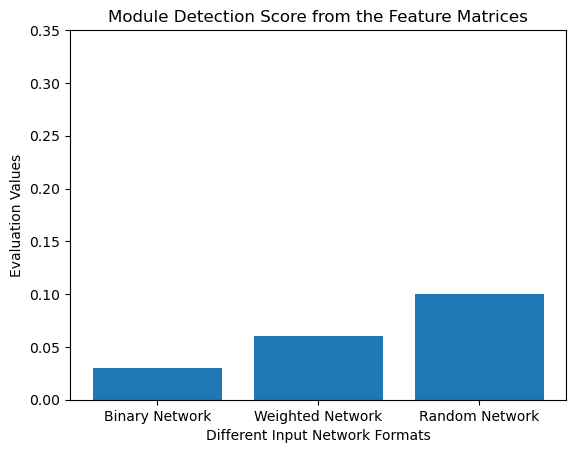

In [12]:
# Plot loss results for different input network settings

import matplotlib.pyplot as plt

# Define the data
categories = ['Binary Network', 'Weighted Network', 'Random Network']
values = [0.03, 0.06, 0.10]

# Create the bar plot
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Different Input Network Formats')
plt.ylabel('Evaluation Values')
plt.title('Module Detection Score from the Feature Matrices')

# Display the plot
plt.ylim(0, 0.35)
plt.show()


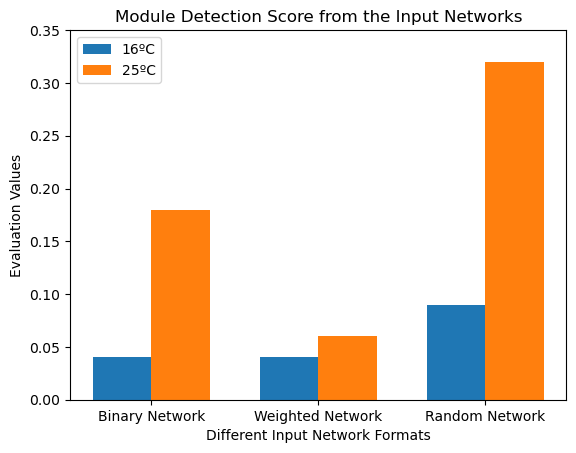

In [11]:
import numpy as np
import matplotlib.pyplot as plt

categories = ['Binary Network', 'Weighted Network', 'Random Network']
values1 = [0.04, 0.04, 0.09]
values2 = [0.18, 0.06, 0.32]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
bar_positions1 = np.arange(len(categories))
bar_positions2 = [x + bar_width for x in bar_positions1]

# Create the bar plot
plt.bar(bar_positions1, values1, width=bar_width, label='16ºC')
plt.bar(bar_positions2, values2, width=bar_width, label='25ºC')

# Customize the plot
plt.xlabel('Different Input Network Formats')
plt.ylabel('Evaluation Values')
plt.title('Module Detection Score from the Input Networks')
plt.xticks(bar_positions1 + bar_width/2, categories)
plt.legend()

# Display the plot
plt.ylim(0, 0.35)
plt.show()
